# Decrypting the Language of Machines


### Session 7

## Shivanand Roy

### What I do?
- Machine Learning
- Deep Learning


### Github: <https://github.com/Shivanandroy>

### Quick Update
---

Google Colaboratory now comes with **TPU** - 
[Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb)


## A Primer on **Neural Network** Models

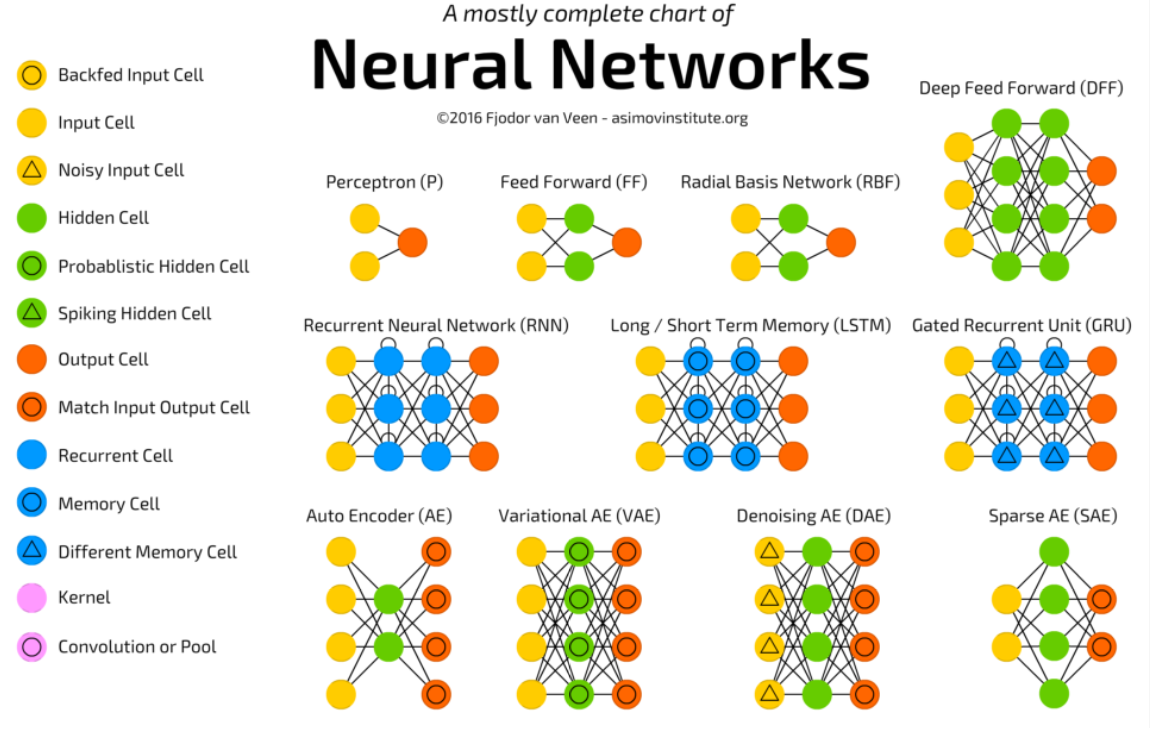

#### some more...
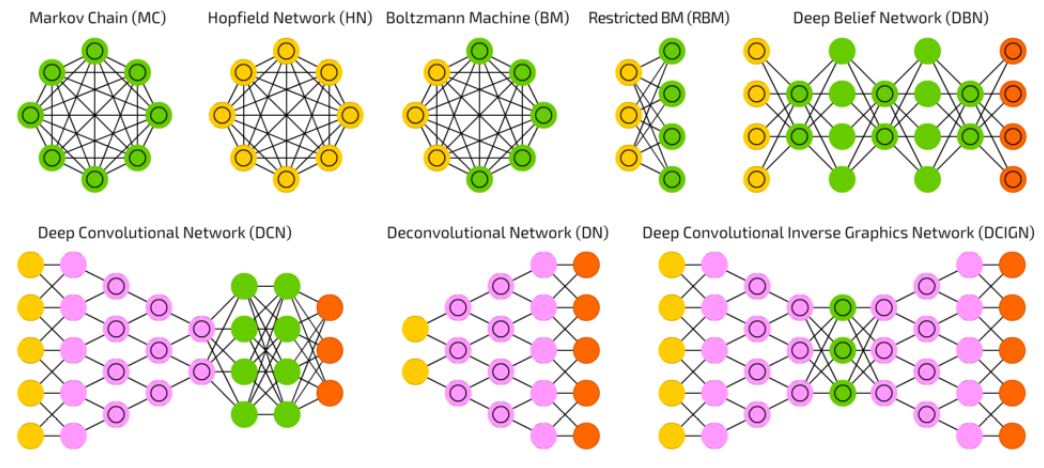

#### And some more...
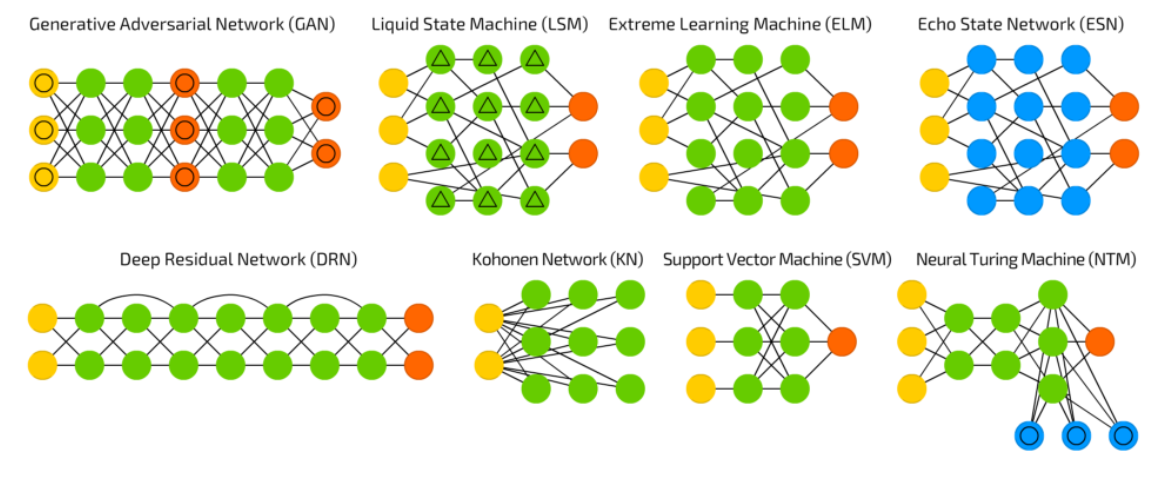

#### A Simple Neural Network Model
---
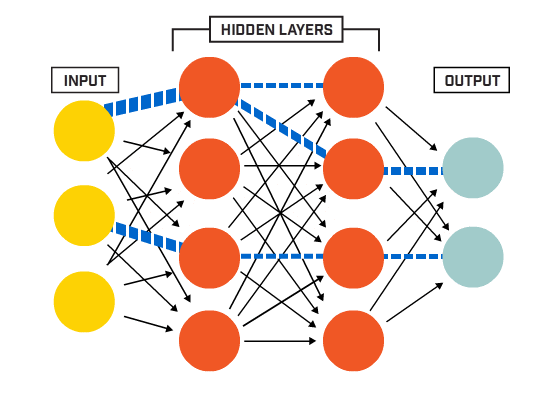

### Inside a Neuron
---
#### input * weight | Activate
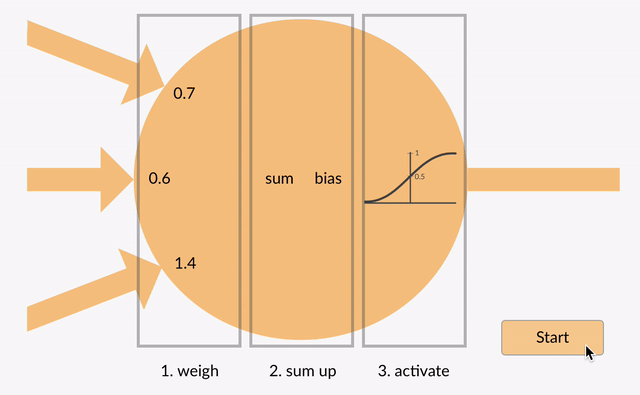

## A Neural Network is an Universal Function Approximator

It can approximate any function given an Input **$X$** and its corrosponding output **$y$** by **learning important features/information between $X$ & $y$**

Can we approximate a function for the given $X$ and $y$ ?

<center>
    
   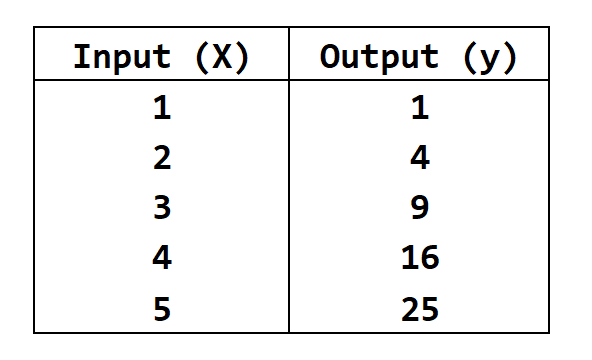
</center>

## <center>$y= X^2$</center>

#### When we

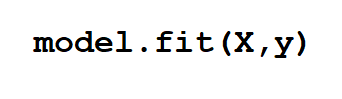

- It learns all the critical features/information between  **$X$ & $y$**
- This information is stored in the hidden layers
- Using this information, it approximates a function such that given an input $X$, it can output $y$

#### What if
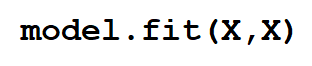


- It learns all the critical features/information between  **$X$ & $X$** i.e. such models can encode critical information of the Input data


- This information is stored in the hidden layers


- Using this information, it approximates a function such that given an input $X$, it can output $X$. i.e. such models can reproduce its input

---
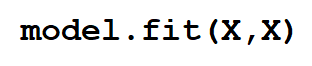

---

- It encodes critical information/features about the input and keeps it in the hidden layers in terms of weights.


- It has the ability to reproduce/ouput its input



### <center>That's the starting idea of *Autoencoders* !</center>

# Autoencoders

## Why Autoencoders ?

### Autoencoders are the entry point to State of the Art Deep Learning Models 

### Denoising Image

---
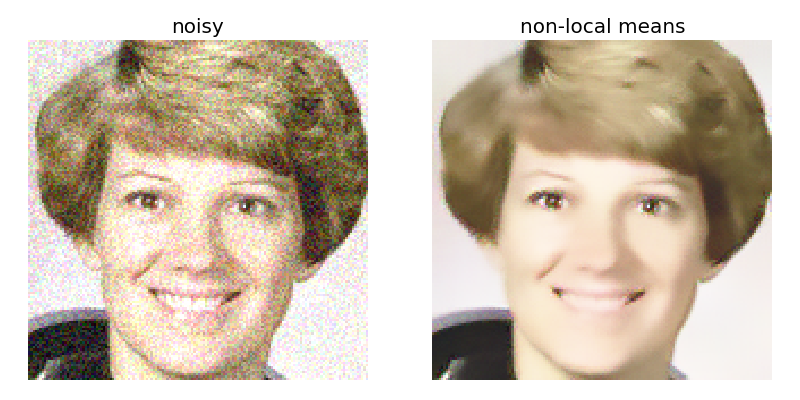

### Anomaly Detection

---
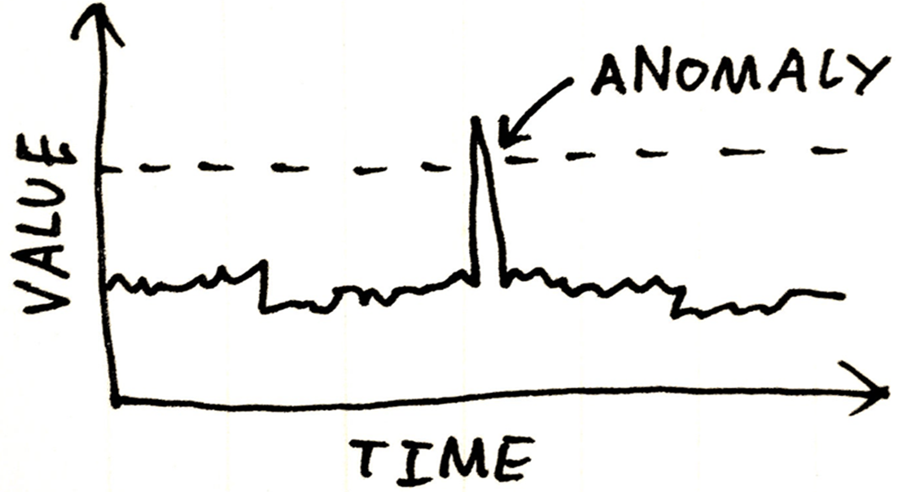

### Image Generation
---
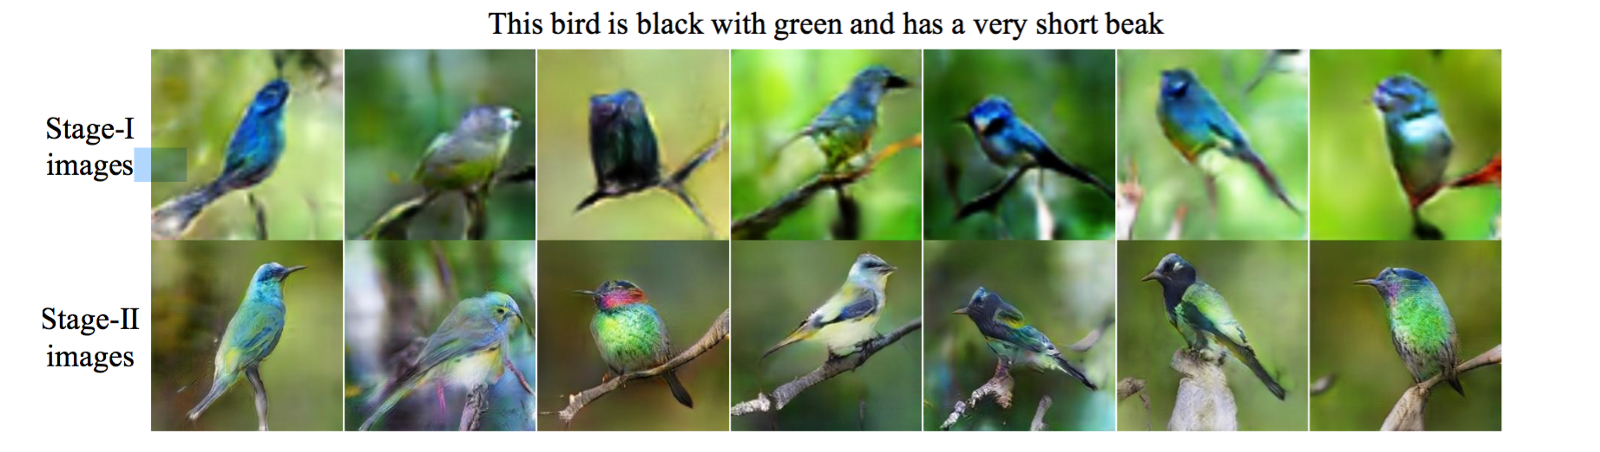

### Image Captioning
---
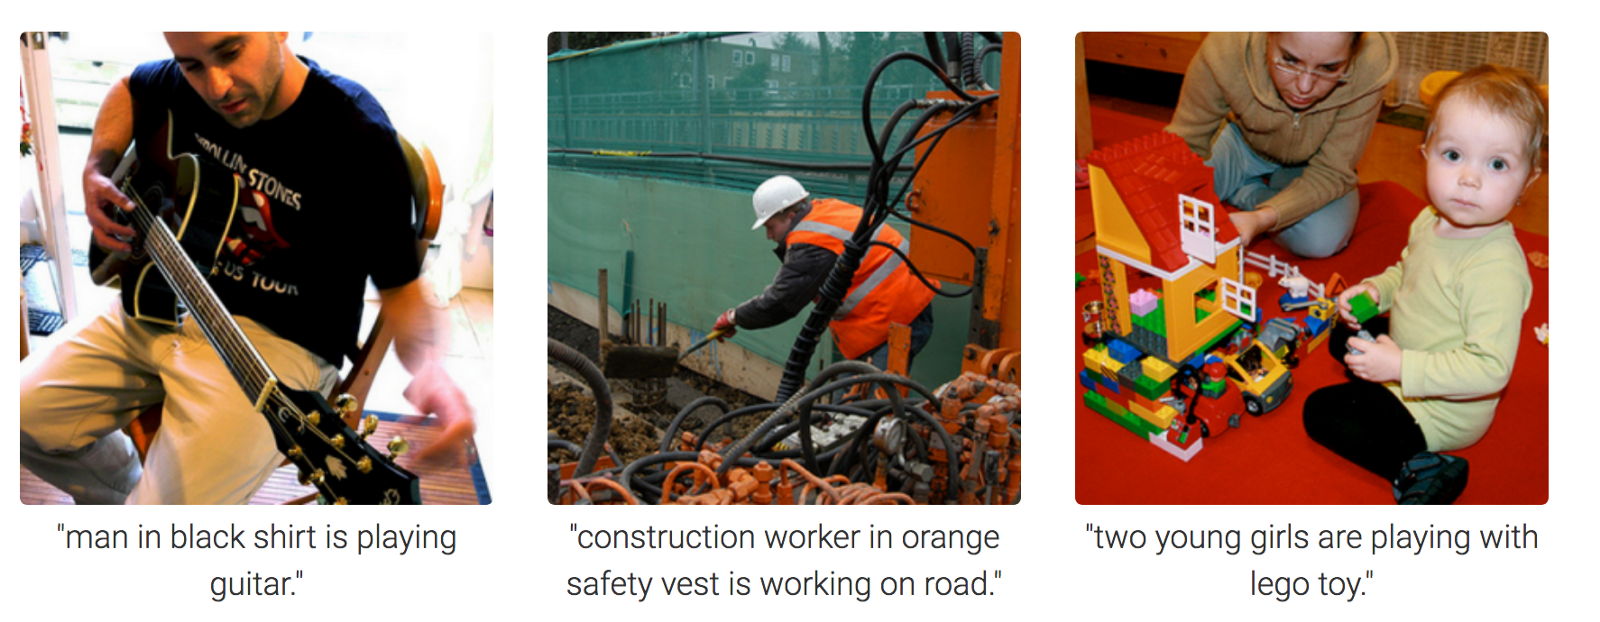

# What are Autoencoders ?

#### Autoencoders are a special type of neural networks in which the output is same as the input. 
---
<center>

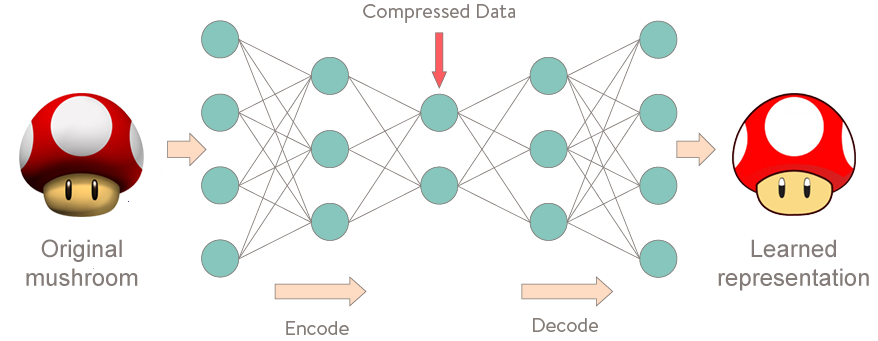
</center>

They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation.



Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data.

#### A typical autoencoder architecture comprises of three main components:

* Encoding Layer 
* Bottleneck Layer
* Decoding Layer
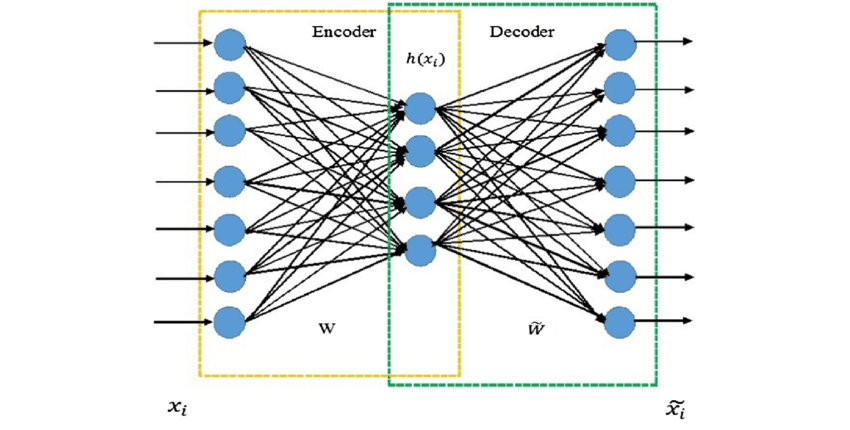

### Encoding Architecture
---
The encoder architecture comprises of series of layers with decreasing number of nodes and ultimately reduces to a latent view repersentation.
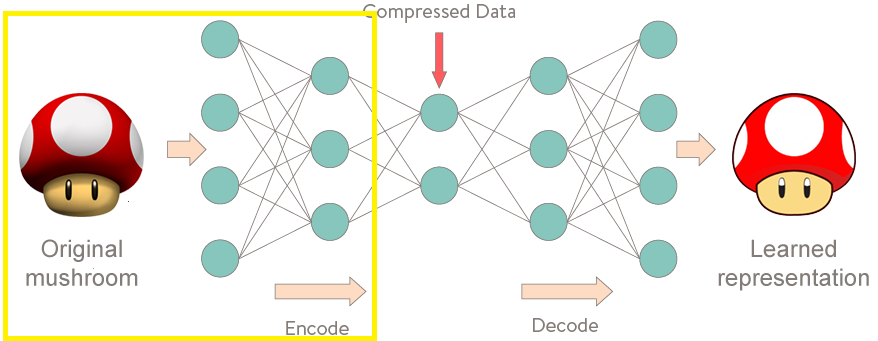

### Latent View Repersentation
---
Latent view repersents the lowest level space in which the inputs are reduced and information is preserved.
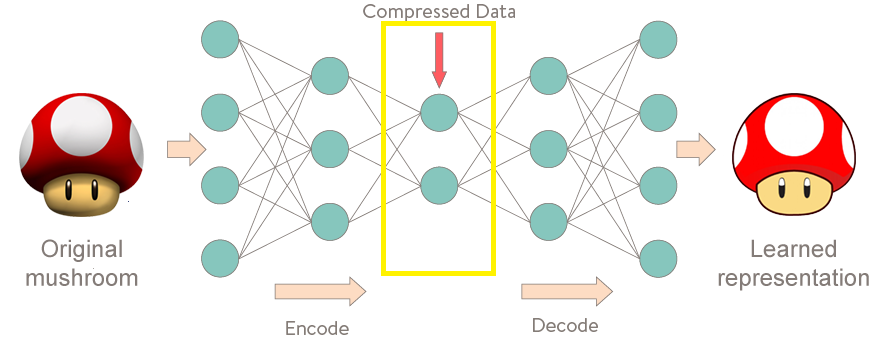

### Decoding Architecture 

The decoding architecture is the mirror image of the encoding architecture but in which number of nodes in every layer increases and ultimately outputs the similar (almost) input.
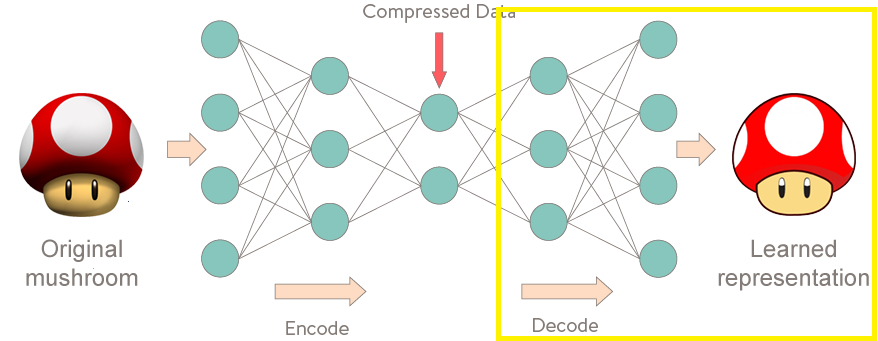

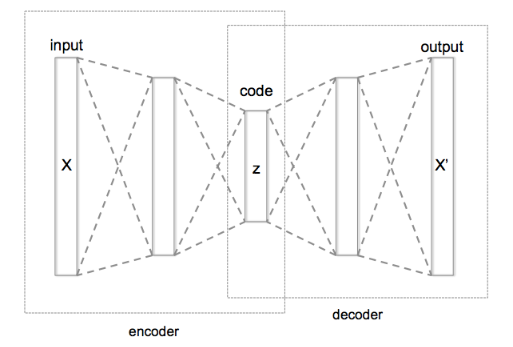
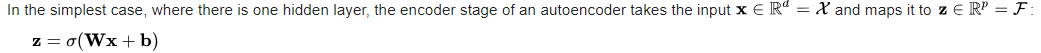
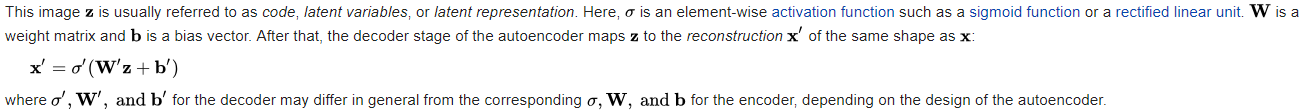
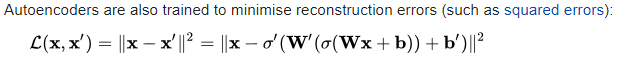

## Types of Autoencoders
---

### Undercomplete Autoencoders
---
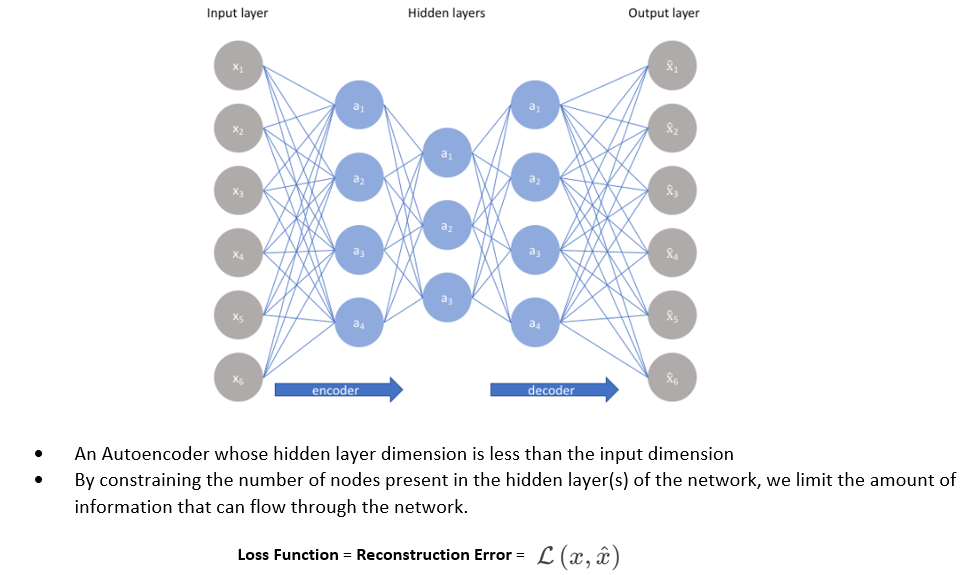



### Sparse Autoencoders
---
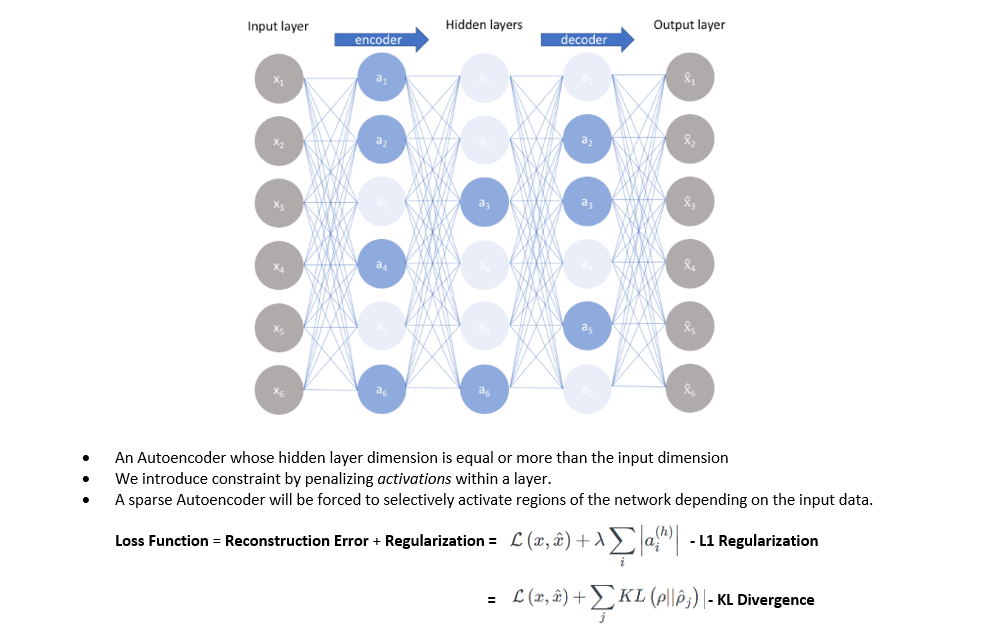


### Denoising Autoencoders
---
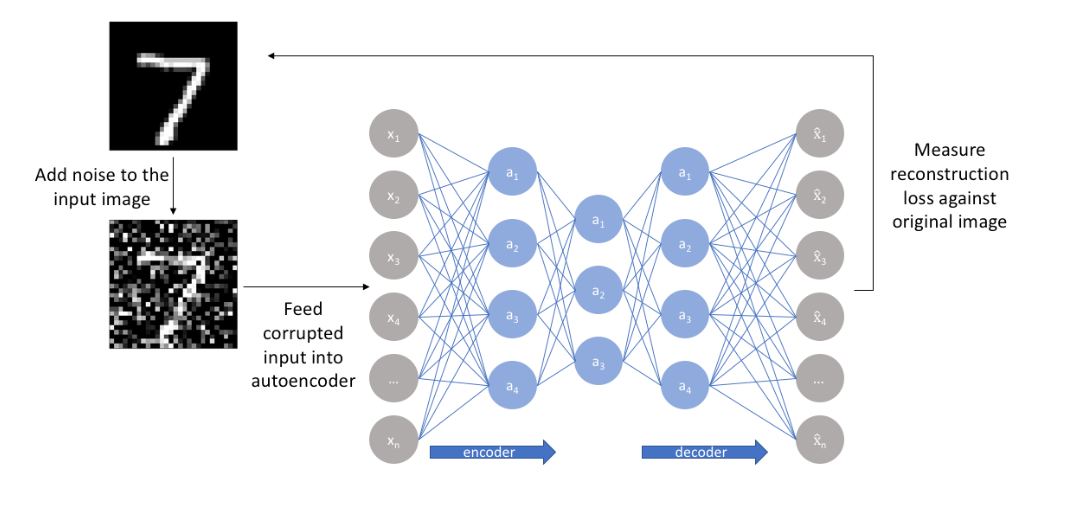

### How can we leverage Autoencoders for Fraud Detection ?

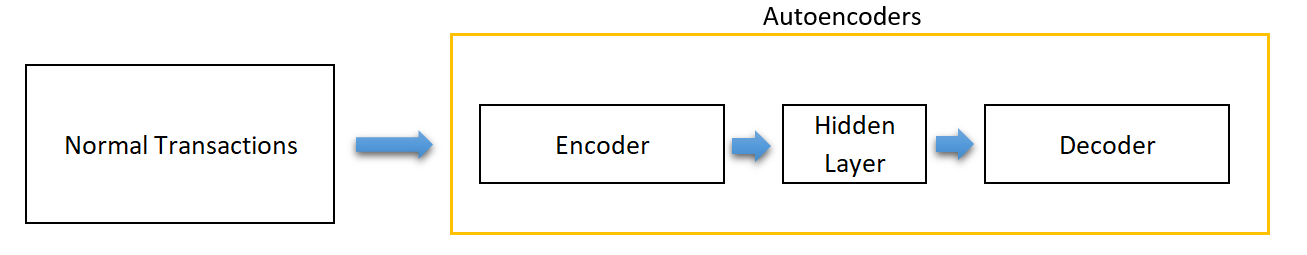

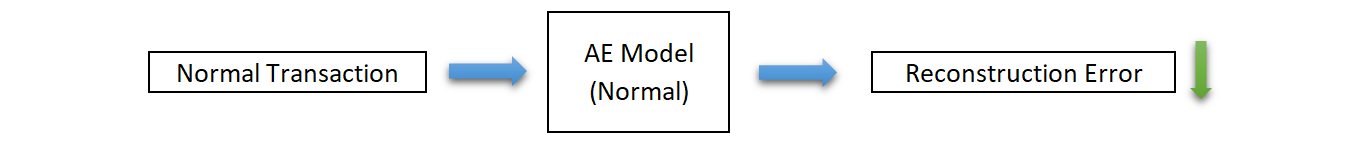

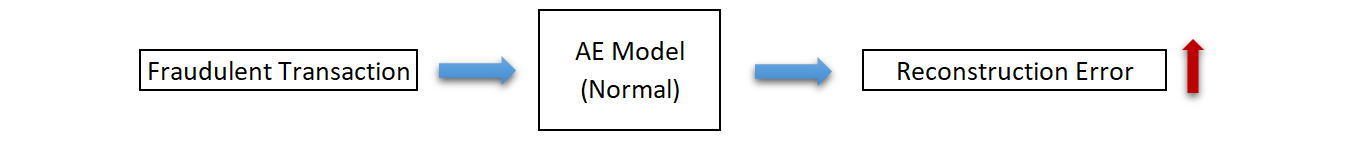

## Let's see it in Action


### [Kaggle Challenge](https://www.kaggle.com/mlg-ulb/creditcardfraud)
---

- The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.
---
- All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. 


## Let's code

### Importing our libraries

In [56]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

print('Done')


Done


In [57]:
# Few more settings for visualization
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12,6 

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

print('Done')

Done


### Fetching our dataset

In [58]:
df = pd.read_csv('data/creditcard.csv')
print('Done')

Done


# Exploration

In [59]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [60]:
df.isnull().values.any()

False

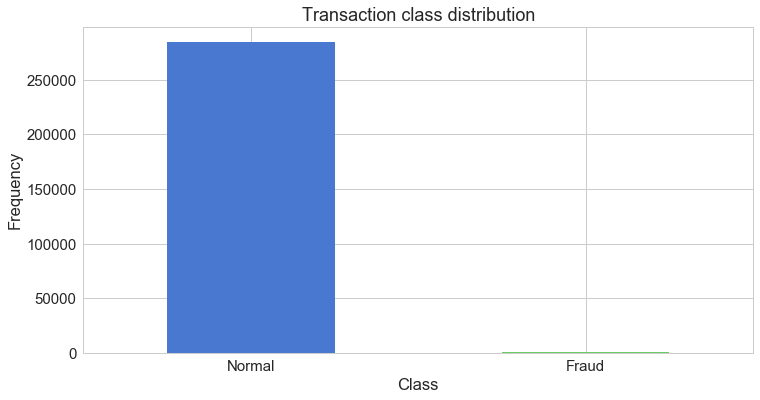

In [61]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands.


Normal transactions overwhelm the fraudulent ones by a large margin. 
Let's look at the two types of transactions: 

In [62]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [63]:
frauds.shape

(492, 31)

In [64]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

Let's have a more graphical representation:

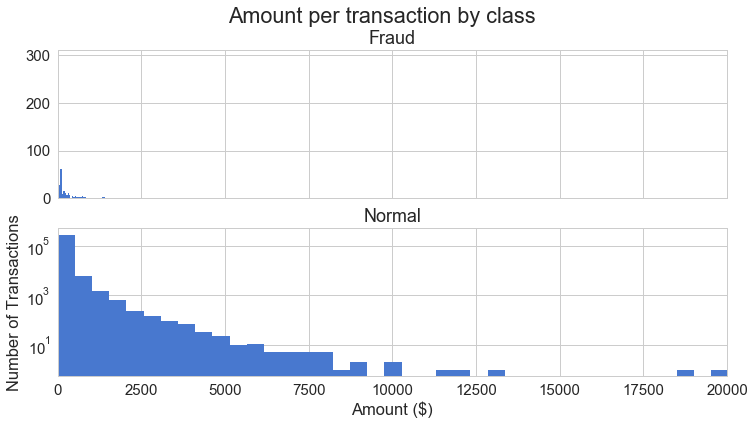

In [67]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

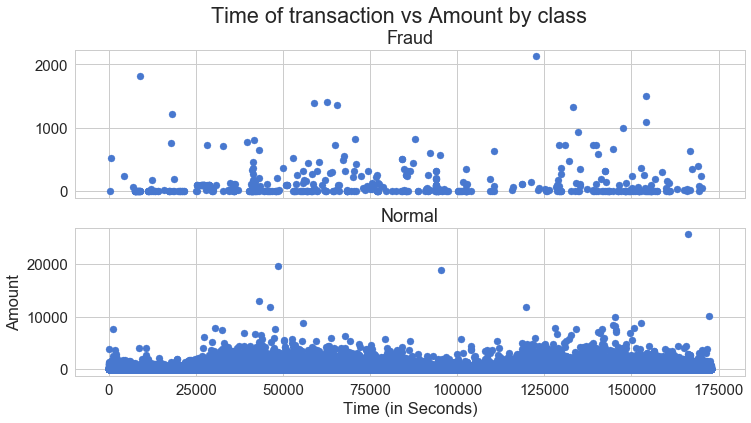

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

# Preparing the data
---

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [69]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Training
---
Training our Autoencoder is gonna be a bit different from what we are used to. 

---
Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions.

---
We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [70]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [71]:
X_train.shape

(227451, 29)

## Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 14 neurons respectively. 

---
The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

### Setting up the Architecture
---

In [72]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim ), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

print('Autoencoder setup complete!')

Autoencoder setup complete!


Let's train our model for **100 epochs** with a **batch size of 32** samples and save the best performing model to a file. 

---

The ModelCheckpoint provided by Keras is really handy for such tasks. 

---
Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [73]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",verbose=0,save_best_only=True)
history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test, X_test),verbose=1,callbacks=[checkpointer]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
 76352/227451 [=========>....................] - ETA: 5s - loss: 0.9008 - acc: 0.5221

KeyboardInterrupt: 

## Let's use the model
---

In [74]:
autoencoder = load_model('model.h5')

print('Model Loaded! Ready for use!!')

Model Loaded! Ready for use!!


# Evaluation

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [75]:
predictions = autoencoder.predict(X_test)

In [76]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

## Reconstruction error without fraud

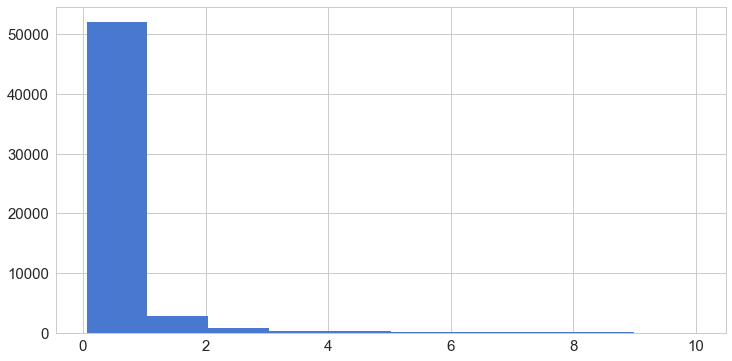

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

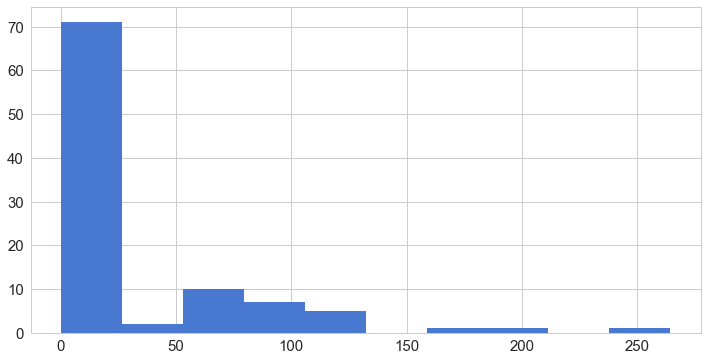

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [80]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers.

---
However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

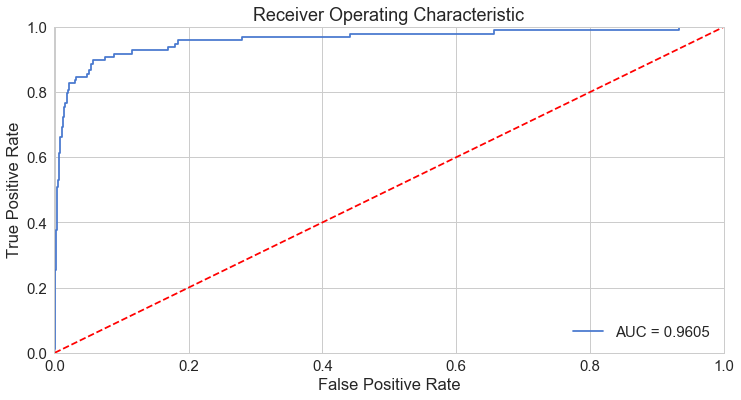

In [81]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# Prediction

---
- In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. 
---
- If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [86]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

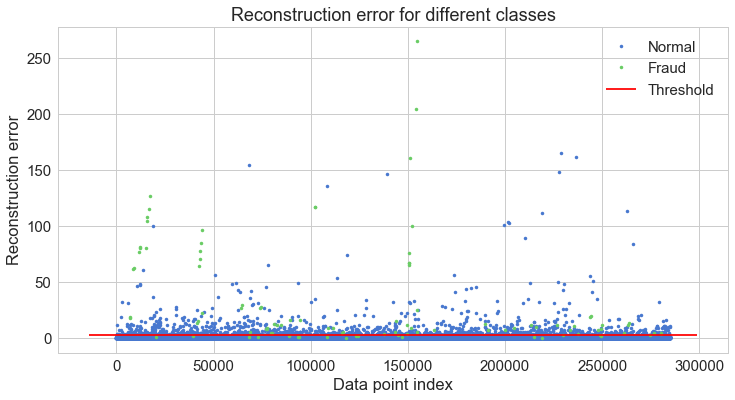

In [87]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

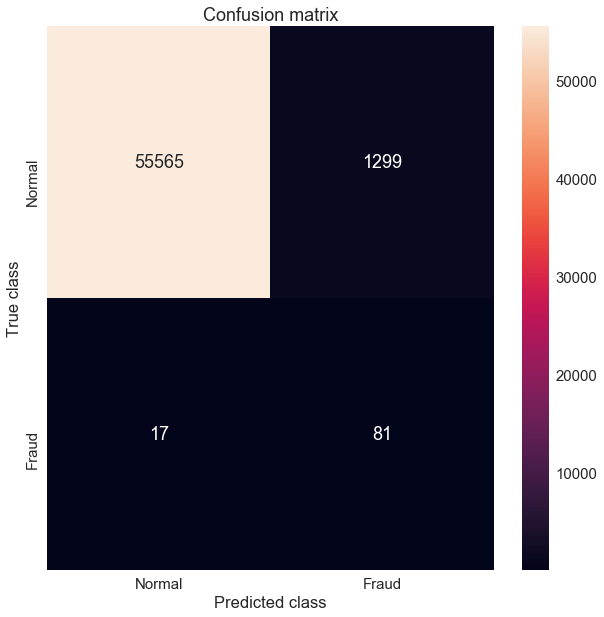

In [88]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Recall = **~83%**

---
We are able to identify ~83% of our fraudulent transactions.

---
With such a **small architecture** we are able to achieve ~83% (Recall)
although at the cost of very low Precision.


## Results

- Our model seems to catch a lot of the fraudulent cases. 
---

- Of course, there is a catch. The number of normal transactions classified as frauds is really high.

---
- You might want to 
 - increase or decrease the value of the threshold
 - build more dense/deep autoencoder architecture



# Conclusion


Think about it,
- We have used Unsupervised way to classify normal and fraudulent transactions.
- We gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class.



# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)
- [Jeremy Jordan-Introduction to autoencoders.](https://www.jeremyjordan.me/autoencoders/)
- [curiousily](http://curiousily.com/)

# <center>Thank You For Joining</center>